- tanh 말고 relu 써도 성능 별 차이없음
- DNN은 문서의 벡터, RNN은 단어의 벡터가 입력
- 위로는 ht만 보냄. 옆으로는 ct, ht
- 데이터 많으면 tf.keras.layers.LSTM 어중간하면 GRU 성능 우수(몇만개)
- tf.keras.layers.LSTM, GRU도 기억 소실을 완전히 해결하지는 못함 -> attention 등장
- 7:3으로 학습과정, 테스트 과정 나눔(과적합 방지)
- Wx, Wh, b는 time step마다 달라지지 않음(고정)
- 30 + 9 + 3
- time step이랑 param #은 상관없음
- 엘모 : 임베딩용 / 버트 : 임베딩 or LM 자체
- tf.keras.layers.Bidirectional로는 LM 만들수없다(autoregressive 모델)

In [364]:
import pandas as pd
import numpy as np
import tensorflow as tf
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import string
from hanspell import spell_checker
from tqdm.notebook import tqdm
from soynlp.normalizer import *
import MeCab
from konlpy.tag import *
import json
import re
from sklearn.model_selection import train_test_split

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mcb = Mecab()

tqdm.pandas()

plt.style.use("dark_background")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## 1. RNN(Recurrent Neural Network)

### 1-1. Numpy로 순환 신경망 구현하기
- t 시점의 hidden state
$$h_{t} = \tanh(W_hh_{t-1} + W_tx_t + b)$$

In [2]:
#시점의 수. NLP에서는 보통 문장의 길이가 된다.
timesteps = 10
#입력의 차원. NLP에서는 보통 단어 벡터의 차원이 된다.
input_dim = 4
#은닉 상태의 크기. 메모리 셀의 용량입니다.
hidden_size = 8

#입력에 해당되는 2D 텐서
inputs = np.random.random((timesteps, input_dim))

#은닉 상태의 크기 hidden_size로 은닉 상태를 만든다.
h_t = np.zeros((hidden_size,)) # 초기 은닉 상태는 0(벡터)로 초기화

Wx = np.random.random((hidden_size, input_dim))
Wh = np.random.random((hidden_size, hidden_size))
b = np.random.random((hidden_size,))

In [3]:
hidden_states = []
for x_t in inputs: # 각 시점에 따라서 입력값이 입력됨.
    temp = np.tanh(np.dot(Wh, h_t) + np.dot(Wx, x_t) + b)
    hidden_states.append(temp)
    h_t = temp

#(timesteps, output_dim)의 shape로 만듭니다.
hidden_states = np.stack(hidden_states, axis=0) 

### 1-2. TensorFlow로 구현하기

#### (1) SimpleRNN

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=3, input_shape=(2, 10)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


- 참고로 time_step은 파라미터 수에 전혀 영향을 주지 않습니다.  
- 출력값이 (batch_size, output_dim) 크기의 2D 텐서일 때, output_dim은 hidden_size의 값인 3입니다. 이 경우 batch_size를 현 단계에서는 알 수 없으므로 (None, 3)이 됩니다. 이번에는 batch_size를 미리 정의해보겠습니다.

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=3, batch_input_shape=(8, 2, 10)))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (8, 3)                    42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


- batch_size를 8로 기재하자, 출력의 크기가 (8, 3)이 된 것을 볼 수 있습니다.
- 이제 return_sequences 매개 변수에 True를 기재하여 출력값으로 (batch_size, timesteps, output_dim) 크기의 3D 텐서를 리턴하도록 모델을 만들어 보도록 하겠습니다.

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=3, batch_input_shape=(8, 2, 10), return_sequences=True))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (8, 2, 3)                 42        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


#### (2) Deep RNN(은닉층이 2개인 깊은 순환 신경망)

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=hidden_size, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(units=hidden_size, return_sequences=True))

#### (3) Bidirectional RNN(양방향 순환 신경망)

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(units=hidden_size, return_sequences=True), input_shape=(timesteps, input_dim)))

#### (4) Deep Bidirecional RNN(깊은 양방향 순환 신경망)

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True), input_shape=(timesteps, input_dim)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(hidden_size, return_sequences=True)))

#### (5) LSTM

In [10]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=hidden_size, input_shape=(timesteps, input_dim)))

#### (6) GRU 구현하기

In [11]:
# 실제 GRU 은닉층을 추가하는 코드.
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(units=hidden_size, input_shape=(timesteps, input_dim)))

### 1-3. 로이터 뉴스 분류하기

In [12]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=None, test_split=0.2)

In [40]:
print(len(X_train))
print(len(X_test))
n_clss = len(set(y_train))
print(n_clss)

8982
2246
46


In [18]:
np.mean(list(map(len, X_train)))

145.5398574927633

뉴스 기사의 최대 길이 : 2376
뉴스 기사의 평균 길이 : 145.5398574927633


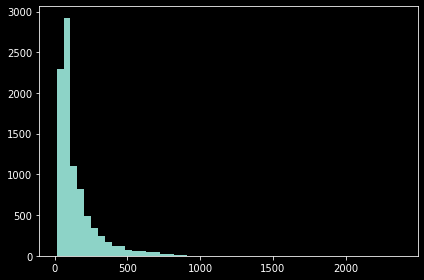

In [26]:
print(f"뉴스 기사의 최대 길이 : {max([len(doc) for doc in X_train])}")
print(f"뉴스 기사의 평균 길이 : {np.mean(list(map(len, X_train)))}")

fig, ax = plt.subplots()

plt.hist([len(doc) for doc in X_train], bins=50)

fig.tight_layout()

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


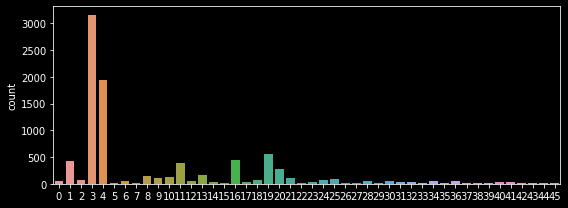

In [37]:
fig, ax = plt.subplots(figsize=(8, 3))

sb.countplot(y_train)

fig.tight_layout()

In [42]:
clss, counts = np.unique(y_train, return_counts=True)

cls2cnt = dict(zip(unique_elements, counts_elements))

In [44]:
print(cls2cnt)

{0: 55, 1: 432, 2: 74, 3: 3159, 4: 1949, 5: 17, 6: 48, 7: 16, 8: 139, 9: 101, 10: 124, 11: 390, 12: 49, 13: 172, 14: 26, 15: 20, 16: 444, 17: 39, 18: 66, 19: 549, 20: 269, 21: 100, 22: 15, 23: 41, 24: 62, 25: 92, 26: 24, 27: 15, 28: 48, 29: 19, 30: 45, 31: 39, 32: 32, 33: 11, 34: 50, 35: 10, 36: 49, 37: 19, 38: 19, 39: 24, 40: 36, 41: 30, 42: 13, 43: 21, 44: 12, 45: 18}


In [54]:
word2idx = tf.keras.datasets.reuters.get_word_index()

idx2word = {}
for key, value in word2idx.items():
    idx2word[value] = key

In [55]:
# for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
#     idx2word[index]=token

print(" ".join([idx2word[index] for index in X_train[0]]))

the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs


## 모델 설계하기

In [59]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.reuters.load_data(num_words=1000, test_split=0.2)

max_len = 100

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [71]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=1000, output_dim=120))
model.add(tf.keras.layers.LSTM(units=120))
model.add(tf.keras.layers.Dense(units=46, activation="softmax"))

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=4)
filepath = "best_model.h5"
mc = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor="val_acc", mode="auto", verbose=1, save_best_only=True)

patience는 '현재 최고 성능'을 기준으로 더 나아지지 않는 경우를 연속 n번까지는 참는다입니다. 예를 들어서 patience가 2라고 했을 때 멈추는 경우는 다음과 같습니다.  

val_loss: 0.5921 < 현재 최고 성능  
val_loss: 0.5731 < 현재 최고 성능  
val_loss: 0.5956 < 1번 참음  
val_loss: 0.5753 < 2번 참음 (loss가 직전 대비 줄은 것과는 상관 없음)  
val_loss: 0.5977 < 더 이상 못 참으므로 중단

In [72]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["sparse_categorical_accuracy"])

hist = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))

Epoch 1/30
71/71 [==============================] - 19s 266ms/step - loss: 2.6363 - sparse_categorical_accuracy: 0.3459 - val_loss: 2.3799 - val_sparse_categorical_accuracy: 0.3620
Epoch 2/30
71/71 [==============================] - 18s 256ms/step - loss: 2.1126 - sparse_categorical_accuracy: 0.4701 - val_loss: 2.0080 - val_sparse_categorical_accuracy: 0.5125
Epoch 3/30
71/71 [==============================] - 18s 249ms/step - loss: 1.9639 - sparse_categorical_accuracy: 0.5085 - val_loss: 1.8535 - val_sparse_categorical_accuracy: 0.5254
Epoch 4/30
71/71 [==============================] - 17s 245ms/step - loss: 1.9952 - sparse_categorical_accuracy: 0.5086 - val_loss: 1.9585 - val_sparse_categorical_accuracy: 0.5205
Epoch 5/30
71/71 [==============================] - 18s 249ms/step - loss: 1.7788 - sparse_categorical_accuracy: 0.5523 - val_loss: 1.7321 - val_sparse_categorical_accuracy: 0.5579
Epoch 6/30
71/71 [==============================] - 25s 358ms/step - loss: 1.6907 - sparse_cate

Epoch 24/30
71/71 [==============================] - 17s 240ms/step - loss: 0.7610 - sparse_categorical_accuracy: 0.8086 - val_loss: 1.1893 - val_sparse_categorical_accuracy: 0.7182
Epoch 25/30
71/71 [==============================] - 17s 245ms/step - loss: 0.7071 - sparse_categorical_accuracy: 0.8238 - val_loss: 1.2038 - val_sparse_categorical_accuracy: 0.7168
Epoch 26/30
71/71 [==============================] - 17s 240ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.8264 - val_loss: 1.2527 - val_sparse_categorical_accuracy: 0.7102
Epoch 27/30
71/71 [==============================] - 17s 239ms/step - loss: 0.6827 - sparse_categorical_accuracy: 0.8278 - val_loss: 1.2166 - val_sparse_categorical_accuracy: 0.7231
Epoch 00027: early stopping


In [70]:
model.load_weights(filepath)

OSError: Unable to open file (unable to open file: name = 'best_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [73]:
model_load = tf.keras.models.load_model(filepath)

print("\n 테스트 정확도: %.4f" % (model_load.evaluate(X_test, y_test)[1]))

OSError: SavedModel file does not exist at: best_model.h5/{saved_model.pbtxt|saved_model.pb}

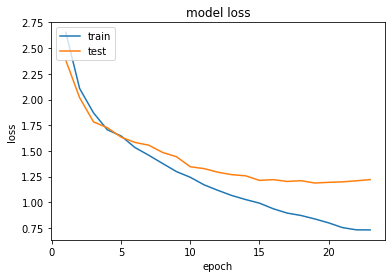

In [ ]:
epochs = range(1, len(history.history["acc"]) + 1)

plt.plot(epochs, history.history["loss"])
plt.plot(epochs, history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# 4. IMDB 리뷰 분류하기

In [ ]:
# 영화 리뷰는 X_train에, 감성 정보는 y_train에 저장된다.
# 테스트용 리뷰는 X_test에, 테스트용 리뷰의 감성 정보는 y_test에 저장된다.
(X_train, y_train), (X_test, y_test) = imdb.load_data()
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = 10000)

17465344/17464789 [==============================] - 0s 0us/step


In [ ]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = max(y_train) + 1
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [ ]:
print(X_train[0])
print(y_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


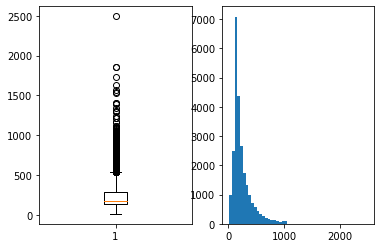

In [ ]:
len_result = [len(s) for s in X_train]

print('리뷰의 최대 길이 : {}'.format(np.max(len_result)))
print('리뷰의 평균 길이 : {}'.format(np.mean(len_result)))

plt.subplot(1,2,1)
plt.boxplot(len_result)
plt.subplot(1,2,2)
plt.hist(len_result, bins=50)
plt.show()

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 레이블에 대한 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 레이블에 대한 빈도수:
[[    0     1]
 [12500 12500]]


In [ ]:
word_to_index = imdb.get_word_index()
index_to_word={}
for key, value in word_to_index.items():
    index_to_word[value] = key

1646592/1641221 [==============================] - 0s 0us/step


In [ ]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

print(' '.join([index_to_word[index] for index in X_train[0]]))

<sos> as you with out themselves powerful lets loves their becomes reaching had journalist of lot from anyone to have after out atmosphere never more room titillate it so heart shows to years of every never going villaronga help moments or of every chest visual movie except her was several of enough more with is now current film as you of mine potentially unfortunately of you than him that with out themselves her get for was camp of you movie sometimes movie that with scary but pratfalls to story wonderful that in seeing in character to of 70s musicians with heart had shadows they of here that with her serious to have does when from why what have critics they is you that isn't one will very to as itself with other tricky in of seen over landed for anyone of gilmore's br show's to whether from than out themselves history he name half some br of 'n odd was two most of mean for 1 any an boat she he should is thought frog but of script you not while history he heart to real at barrel but w

In [ ]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = 5000)

In [ ]:
max_len = 500
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
model = Sequential()
model.add(Embedding(5000, 120))
model.add(LSTM(120))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[es, mc])

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.4457 - acc: 0.7867
Epoch 00001: val_acc improved from -inf to 0.85164, saving model to best_model.h5
391/391 [==============================] - 24s 62ms/step - loss: 0.4455 - acc: 0.7868 - val_loss: 0.3473 - val_acc: 0.8516
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.3500 - acc: 0.8530
Epoch 00002: val_acc did not improve from 0.85164
391/391 [==============================] - 24s 61ms/step - loss: 0.3500 - acc: 0.8530 - val_loss: 0.7200 - val_acc: 0.5554
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3646 - acc: 0.8420
Epoch 00003: val_acc improved from 0.85164 to 0.86956, saving model to best_model.h5
391/391 [==============================] - 24s 62ms/step - loss: 0.3646 - acc: 0.8420 - val_loss: 0.3250 - val_acc: 0.8696
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.3070 - acc: 0.8748
Epoch 00004: val_acc did not improve from 0.86956


In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 10s 13ms/step - loss: 0.3467 - acc: 0.8747

 테스트 정확도: 0.8747


## 5. 네이버 영화 리뷰 데이터 감성 분류

### 5-1. LSTM 사용하기

In [19]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x19fbf575748>)

In [62]:
train_data = pd.read_table("ratings_train.txt")
test_data = pd.read_table("ratings_test.txt")

train_data["document"] = train_data["document"].str.replace(f"[{string.punctuation}]", " ")
train_data["document"] = train_data["document"].str.replace(r" +", " ")
train_data = train_data[train_data["document"]!=" "]
train_data = train_data.dropna(axis=0)

test_data["document"] = test_data["document"].str.replace(f"[{string.punctuation}]", " ")
test_data["document"] = test_data["document"].str.replace(r" +", " ")
test_data = test_data[test_data["document"]!=" "]
test_data = test_data.dropna(axis=0)

<AxesSubplot:>

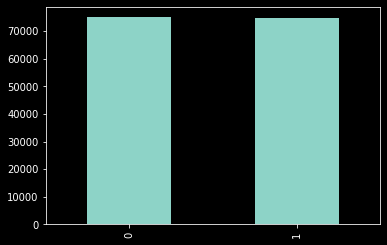

In [63]:
train_data["label"].value_counts().plot(kind="bar")

In [68]:
train_docs = train_data["document"].tolist()
test_docs = test_data["document"].tolist()

train_corp = []
for doc in tqdm(train_docs):
    train_corp.append(mcb.morphs(doc))
    
test_corp = []
for doc in tqdm(test_docs):
    test_corp.append(mcb.morphs(doc))

In [34]:
# path = "imdb_okt"
# with open(path, "w", encoding="utf-8") as f:		
#     json.dump(X_train, f, ensure_ascii=False, indent="\t")	

### TF-IDF를 이용한 벡터화 (선택적)

In [ ]:
# vocab_size = 5000

# tokenizer = Tokenizer(num_words = vocab_size)
# tokenizer.fit_on_texts(X_train)

# tfidf_train = tokenizer.texts_to_matrix(X_train, mode='tfidf') # 샘플 수 × vocab_size 크기의 행렬 생성
# tfidf_test = tokenizer.texts_to_matrix(X_test, mode='tfidf') # 샘플 수 × vocab_size 크기의 행렬 생성

# y_train = np.array(train_data['label'])
# y_test = np.array(test_data['label'])

# print('훈련 샘플 본문의 크기 : {}'.format(tfidf_train.shape))
# print('훈련 샘플 레이블의 크기 : {}'.format(tfidf_test.shape))
# print('테스트 샘플 본문의 크기 : {}'.format(len(X_train)))
# p rint('테스트 샘플 레이블의 크기 : {}'.format(len(y_test)))

## 다층 퍼셉트론으로 네이버 영화 리뷰 분류하기 (선택적)

In [100]:
# model = Sequential()
# model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(2, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.fit(tfidf_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
# score = model.evaluate(tfidf_test, y_test, batch_size=128, verbose=0)

In [176]:
X_train = train_corp
X_test = test_corp

tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(X_train)

word2idx = tkn.word_index
word2cnt = sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True)

cnts = [value for key, value in word2cnt]
tot_cnts = sum(cnts)
ratio = 0.99

temp = 0
for idx, cnt in enumerate(cnts):
    temp += cnt
    if temp >= tot_cnts * ratio:
        break
vocab_size = idx

print(f"{vocab_size:,}개의 단어 사용 시 전체 문장의 {ratio:.0%}를 나타낼 수 있습니다.")
print(f"이는 전체 단어 갯수의 {idx/len(word2idx):.1%}에 해당합니다.")
print(f"{vocab_size:,}번째 단어의 등장 횟수는 {cnt}회입니다.")

28,379개의 단어 사용 시 전체 문장의 99%를 나타낼 수 있습니다.
이는 전체 단어 갯수의 54.6%에 해당합니다.
28,379번째 단어의 등장 횟수는 2회입니다.


In [177]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+2, oov_token="OOV") 
tkn.fit_on_texts(X_train)

X_train = tkn.texts_to_sequences(X_train)
X_test = tkn.texts_to_sequences(X_test)

y_train = np.array(train_data["label"])
y_test = np.array(test_data["label"])

# 빈 샘플들을 제거
idx_drop = [idx for idx, doc in enumerate(X_train) if len(doc) == 0]

X_train = np.delete(X_train, idx_drop, axis=0)
y_train = np.delete(y_train, idx_drop, axis=0)

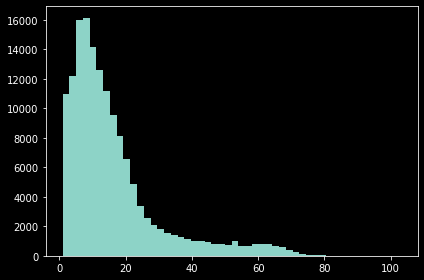

In [99]:
lens = [len(doc) for doc in X_train]

fig, ax = plt.subplots()

ax.hist(lens, bins=50)

fig.tight_layout()

In [157]:
print(f"최대 길이 : {max(lens)}")
print(f"평균 길이 : {np.mean(lens)}")

최대 길이 : 103
평균 길이 : 16.47760964795128


In [178]:
ratio = 0.99
for max_len in range(max(lens)):
    if len([len for len in lens if len <= max_len]) >= len(lens)*ratio:
        break
print(max_len)

67


- 길이가 67 이하인 샘플이 99%를 차지합니다.

In [179]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

### 5-?. LSTM

In [182]:
model = tf.keras.Sequential()
emb_dim = 100
model.add(tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=emb_dim))
hidden_size = 128
# model.add(tf.keras.layers.LSTM(units=hidden_size))
model.add(tf.keras.layers.LSTM(units=hidden_size, input_shape=(max_len, emb_dim)))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=4)
model_path = "Naver_movie_LSTM.h5"
mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor="val_binary_accuracy", mode="auto", verbose=1, save_best_only=True)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["binary_accuracy"])

batch_size = 128
hist = model.fit(x=X_train, y=y_train, callbacks=[es, mc], batch_size=batch_size, epochs=15, validation_split=0.2, verbose=1)

Epoch 1/15
936/936 [==============================] - ETA: 0s - loss: 0.3882 - binary_accuracy: 0.8277
Epoch 00001: val_binary_accuracy improved from -inf to 0.85289, saving model to Naver_movie_LSTM.h5
936/936 [==============================] - 205s 219ms/step - loss: 0.3882 - binary_accuracy: 0.8277 - val_loss: 0.3450 - val_binary_accuracy: 0.8529
Epoch 2/15
936/936 [==============================] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8678
Epoch 00002: val_binary_accuracy improved from 0.85289 to 0.86528, saving model to Naver_movie_LSTM.h5
936/936 [==============================] - 218s 232ms/step - loss: 0.3109 - binary_accuracy: 0.8678 - val_loss: 0.3142 - val_binary_accuracy: 0.8653
Epoch 3/15
936/936 [==============================] - ETA: 0s - loss: 0.2799 - binary_accuracy: 0.8833
Epoch 00003: val_binary_accuracy did not improve from 0.86528
936/936 [==============================] - 209s 224ms/step - loss: 0.2799 - binary_accuracy: 0.8833 - val_loss: 0.3190 - val_bin

KeyboardInterrupt: 

In [189]:
model = tf.keras.models.load_model(model_path)

model.evaluate(x=X_test, y=y_test, batch_size=batch_size, verbose=1)

1561/1561 [==============================] - 39s 25ms/step - loss: 0.3005 - binary_accuracy: 0.8731


[0.3005322217941284, 0.8730924725532532]

In [241]:
def sentiment_predict(sent):
    sent = mcb.morphs(sent)
    seq = tkn.texts_to_sequences([sent])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
    score = float(model.predict(pad))
    print(f"이 문장의 긍정도는 {score:.1%}입니다.")

In [245]:
sentiment_predict("이런거 왜보냐")

이 문장의 긍정도는 9.1%입니다.


In [246]:
sentiment_predict("감독 뭐하는 놈이냐?")

이 문장의 긍정도는 11.3%입니다.


In [247]:
sentiment_predict("와 개쩐다 정말 세계관 최강자들의 영화다")

이 문장의 긍정도는 56.9%입니다.


### 5-2. 1D CNN 사용하기

In [316]:
dropout_rate = (0.5, 0.8)
n_filters = 128
emb_dim = 64
max_len=67

inputs = tf.keras.Input(shape=(max_len,))
z = tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=emb_dim, input_length=max_len)(inputs)
# z = tf.keras.layers.Dropout(dropout_rate[0])(z)

conv_blocks = []
for kernel_size in [3, 4, 5]:
    z2 = tf.keras.layers.Conv1D(filters=n_filters, kernel_size=kernel_size, padding="same", activation="relu", strides=1)(z)
    z2 = tf.keras.layers.GlobalMaxPooling1D()(z2)
#     z2 = tf.keras.layers.Flatten()(z2)
    conv_blocks.append(z2)

z3 = tf.keras.layers.Concatenate(axis=1)(conv_blocks)
# z3 = tf.keras.layers.Dropout(dropout_rate[1])(z3)
z3 = tf.keras.layers.Dense(units=128, activation="relu")(z3)
outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(z3)

model = tf.keras.Model(inputs, outputs)

In [317]:
model.summary()

Model: "functional_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 67)]         0                                            
__________________________________________________________________________________________________
embedding_40 (Embedding)        (None, 67, 64)       1816384     input_23[0][0]                   
__________________________________________________________________________________________________
conv1d_44 (Conv1D)              (None, 67, 128)      24704       embedding_40[0][0]               
__________________________________________________________________________________________________
conv1d_45 (Conv1D)              (None, 67, 128)      32896       embedding_40[0][0]               
______________________________________________________________________________________

- Conv1d를 이해했는지 테스트하는 가장 좋은 방법은 파라미터의 개수를 이해할 수 있느냐를 점검해보는 것입니다. Conv1d의 커널 크기 3짜리의 총 파라미터수는 49,280입니다. 이는 3 * 128 * 128 + 128의 결과입니다. 왜 이런 계산이 나오는지 생각해봅시다.

In [319]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])

model_path = "Naver_movie_CNN.h5"
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=4)
mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor="val_binary_accuracy", mode="auto", verbose=1, save_best_only=True)

hist = model.fit(x=X_train, y=y_train, validation_split=0.2, batch_size=64, epochs=10, verbose=1, callbacks=[es, mc])

Epoch 1/10
1872/1872 [==============================] - ETA: 0s - loss: 0.3404 - binary_accuracy: 0.8502
Epoch 00001: val_binary_accuracy improved from -inf to 0.87092, saving model to Naver_movie_CNN.h5
1872/1872 [==============================] - 192s 103ms/step - loss: 0.3404 - binary_accuracy: 0.8502 - val_loss: 0.3061 - val_binary_accuracy: 0.8709
Epoch 2/10
1872/1872 [==============================] - ETA: 0s - loss: 0.2249 - binary_accuracy: 0.9107
Epoch 00002: val_binary_accuracy did not improve from 0.87092
1872/1872 [==============================] - 192s 102ms/step - loss: 0.2249 - binary_accuracy: 0.9107 - val_loss: 0.3124 - val_binary_accuracy: 0.8684
Epoch 3/10
1872/1872 [==============================] - ETA: 0s - loss: 0.1275 - binary_accuracy: 0.9539
Epoch 00003: val_binary_accuracy did not improve from 0.87092
1872/1872 [==============================] - 185s 99ms/step - loss: 0.1275 - binary_accuracy: 0.9539 - val_loss: 0.3996 - val_binary_accuracy: 0.8592
Epoch 4/10

In [320]:
model = tf.keras.models.load_model(model_path)

model.evaluate(x=X_test, y=y_test, batch_size=batch_size, verbose=1)

391/391 [==============================] - 10s 26ms/step - loss: 0.3155 - binary_accuracy: 0.8638


[0.315510630607605, 0.8638402819633484]

In [321]:
def sentiment_predict(sent):
    sent = mcb.morphs(sent)
    seq = tkn.texts_to_sequences([sent])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
    score = float(model.predict(pad))
    print(f"이 문장의 긍정도는 {score:.1%}입니다.")

In [322]:
sentiment_predict("이런거 왜보냐")

이 문장의 긍정도는 8.7%입니다.


In [323]:
sentiment_predict("감독 뭐하는 놈이냐?")

이 문장의 긍정도는 2.2%입니다.


In [324]:
sentiment_predict("와 개쩐다 정말 세계관 최강자들의 영화다")

이 문장의 긍정도는 88.1%입니다.


## 6. 스팀 리뷰 데이터 감성 분류

In [325]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x19f95705848>)

In [355]:
data = pd.read_table("steam.txt", names=["label", "review"])

In [356]:
data["review"] = data["review"].str.replace(f"[{string.punctuation}]", " ")
data["review"] = data["review"].str.replace(r" +", " ")
data = data[data["review"]!=" "]
data = data.dropna(axis=0)
data = data.drop_duplicates(["review"], keep="first")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


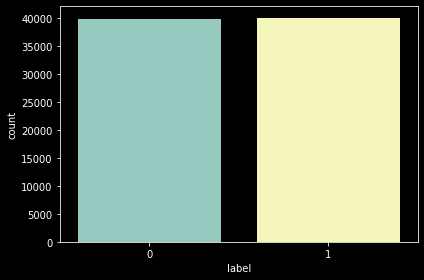

In [345]:
fig, ax = plt.subplots()

sb.countplot(data["label"])

fig.tight_layout()

In [367]:
data["morphs"] = data["review"].progress_apply(mcb.morphs)
# data["pos"] = data["review"].progress_apply(mcb.pos)

train, test = train_test_split(data, train_size=0.8, shuffle=True, random_state=231)

train_X = train["morphs"].tolist()
train_y = np.array(train["label"])

test_X = test["morphs"].tolist()
test_y = np.array(test["label"])

tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(train_X)
word2idx = tkn.word_index
word2cnts = dict(sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True))

cnts = list(word2cnts.values())
ratio = 0.99
for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break

print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")

In [513]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+2, oov_token="OOV")
tkn.fit_on_texts(train_X)

train_X = tkn.texts_to_sequences(train_X)
test_X = tkn.texts_to_sequences(test_X)

lens = sorted([len(doc) for doc in train_X])
for idx, max_len in enumerate(lens):
    if idx/len(lens) >= ratio:
        break
print(f"길이가 {max_len} 이하인 리뷰가 전체의 {ratio:.0%}를 차지합니다.")

In [516]:
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X, maxlen=max_len)
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen=max_len)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=vocab_size+2, output_dim=64))
hidden_size = 128
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_size)))
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "steam_review_bidirectional_lstm.h5"
mc = tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor="val_binary_accuracy", mode="auto", verbose=1, save_best_only=True)

model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["binary_accuracy"])

batch_size = 256
hist = model.fit(x=train_X, y=train_y, validation_split=0.2, batch_size=batch_size, epochs=10, verbose=1, callbacks=[es, mc])

In [517]:
model = tf.keras.models.load_model(model_path)

model.evaluate(x=test_X, y=test_y, batch_size=batch_size, verbose=1)

78/78 [==============================] - 17s 220ms/step - loss: 0.4575 - binary_accuracy: 0.7931


[0.4575434923171997, 0.7930930852890015]

In [518]:
def sentiment_predict(sent):
    sent = mcb.morphs(sent)
    seq = tkn.texts_to_sequences([sent])
    pad = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)
    score = float(model.predict(pad))
    print(f"이 문장의 긍정도는 {score:.1%}입니다.")

In [520]:
sentiment_predict("노잼 ..완전 재미 없음 ㅉㅉ")

이 문장의 긍정도는 3.4%입니다.


In [521]:
sentiment_predict("조금 어렵지만 재밌음ㅋㅋ")

이 문장의 긍정도는 98.7%입니다.


In [527]:
sentiment_predict("케릭터가 예뻐고 재밌기도 합니다만 애매하네요")

이 문장의 긍정도는 34.1%입니다.
